# Physics-Informed Neural Networks (PINNs)

Теоретическая основа: универсальная теорема аппроксимации (доказана Джорджем Цибенко в 1989 году и Куртом Хорником в 1991): \
Однослойная нейроная сеть с достаточно большим числом нейронов и нелинейной гладкой функцией \
(например, sigmoid или tanh) может приблизить любую непрерывную функцию на компактном множестве \
с любой заданной точностью. 

$$
sup_{x \in K}| f(x) - N(x) | < \epsilon
$$

# Уравнение теплопроводности

$$ \frac{\partial u(x,t)}{\partial t}=\frac{\partial}{\partial x}(k(x)*\frac{\partial u(x,t)}{\partial x})+f(x,t)) $$
$$ x \in (0,L), \, t \in (0,T] $$ \
$ u(x,t) $ - температура  \
$ k(x) $ - коэф.теплопроводности \
$ f(x,t) $ - источники \\ стоки
### Начальные условия:
$$ u(x,0)=g_{IC}(x) $$
$$ x \in [0,L], \, t = 0 $$
### Граничные условия (например, первого рода):
$$ u(0,t)=g_{LB}(t), u(L,t)=g_{RB}(t) $$
$$ x \in \{0,L\}, \, t \in (0,T] $$

# Аппроксимация дифференциального уравнения нейроной сетью
$ N_u(x,t) $ - нейросеть аппроксимирует u(x,t),тогда аппроксимированное ур-ие теплопроводности примет вид:
$$
\frac{\partial N_u(x,t)}{\partial t}=\frac{\partial}{\partial x}(k(x) \frac{\partial N_u(x,t)}{\partial x})+f(x,t))
$$

или раскроем производную произведения и перенесем все в левую сторону
$$
\frac{\partial N_u(x,t)}{\partial t} - \frac{\partial k(x)}{\partial x} \frac{\partial N_u(x,t)}{\partial x} - k(x) \frac{\partial^2 N_u(x,t)}{\partial x^2} -f(x,t)) = 0
$$

Производная нейросети $ N_u(x,t) $, состоящая, например, из входа -> два внутренних слоя -> выход - 
это гладкая функция как композиция слоев нейросети \
$$ N_u(x,t) = f_3(f_2(f_1(x,t,\theta), \theta), \theta), $$ \
$ f_1, f_2, f_3 $ - слои нейросети (линейные преобразования + функции активации) \
$ \theta_i $ - обучаемые параметры (веса и смещения) \
производная $  N_u(x,t) $ вычисляется по цепному правилу:
$$
\frac{\partial N_u}{\partial x} = \frac{\partial f_3}{\partial f_2} * \frac{\partial f_2}{\partial f_1} * \frac{\partial f_1}{\partial x}
$$
где каждый член это якобиан (матрица частных производных)

# Функция потерь (loss function)
### 1. Partial Differential Equation loss: ошибка аппроксимации дифф.ур-ия нейронной сетью
$$
L_{PDE} = \frac{1}{M} \sum_{j=1}^M || \frac{\partial N_u(x,t)}{\partial t} - \frac{\partial k(x)}{\partial x} \frac{\partial N_u(x,t)}{\partial x} - k(x) \frac{\partial^2 N_u(x,t)}{\partial x^2} -f(x,t) ||^2
$$
$$ x \in (0,L), t \in (0,T] $$
### 2. Initial condition loss: ошибка нейронной сети по начальным условиям
$$ L_{IC} = \frac{1}{K} \sum_{j=1}^K || N_u(x,0) - g_{IC}(x) ||^2 $$
$$ x \in [0;L], t = 0 $$
### 3. Boundary condition loss: ошибка нейронной сети по граничным условиям
$$ L_{BC} = \frac{1}{P} (\sum_{j=1}^P || N_u(0,t) - g_{LB}(t) ||^2 + \sum_{j=1}^P || N_u(L,t) - g_{RB}(t) ||^2) $$
$$ x \in \{0,L\}, t \in (0,T] $$
### 4. Data loss: ошибка предсказанных и экспериментальных данных
$$ L_{data} = \frac{1}{N} \sum_{j=1}^N || N_u(x,t) - u_{data}(x,t) ||^2 $$
$$ x \in (0,L), t \in (0,T] $$
### Итоговый лосс:
$$ L = \lambda_{PDE} L_{PDE} + \lambda_{IC} L_{IC} + \lambda_{BC} L_{BC} + \lambda_{data} L_{data} $$
пояснение по выбору M,K,P,N пусть 
K - число пропорциональное кол-ву шагов дискретизации по времени, 
P - число пропорциональное кол-ву шагов дискретизации по пространству (в данном случае одномерному)
тогда 
M - будет числом пропорциональным K*P кол-ву шагов дискретизации внутренней области определения
N - кол-во возможных экспериментальных данных, которые попадают во внутреннюю область \
Таким образом:
1. Решаем ПРЯМУЮ ЗАДАЧУ - на выходе получаем PINN физической модели (аппроксимацию дифференциального уравнения в частных производных с учетом нач. и гр. условий)
$$ L_{phys} = \lambda_{PDE} L_{PDE} + \lambda_{IC} L_{IC} + \lambda_{BC} L_{BC} $$
3. Решаем ОБРАТНУЮ ЗАДАЧУ - дополнительно к аппроксимации физической модели $ N_u(x,t) $ добавляем в уравнение аппроксимацию, например, коэффициента теплопроводности $ N_k(x) $ и решаем задачу оптимизации двух PINN сетей  

Пояснение по виду лоссов: $ loss = \frac{1}{N} \sum_{j=1}^N ||x||^2  $, где ||*|| - Евклидова норма. \
Если x - вектор независимых параметров, т.е. $ x \in \{x_1, x_2, ..., x_n\} $
то $ ||x|| = \sqrt {x_1^2 + x_2^2 + ... x_n^2} $ (длина n-мерного вектора)  или $ ||x||^2 = \sum_{i=1}^n x_i^2 $, тогда:
$ loss =  \frac{1}{N} \sum_{j=1}^N (\sum_{i=1}^n x_i^2) $, где первая сумма (справа) - длина n-мерного вектора в квадрате,
а вторая сумма (слева) - среднее значение N длин в квадрате n-мерных векторов \
Если x - это скаляр, тогда: $ loss = \frac{1}{N} \sum_{j=1}^N (x^2) $

# ПРИМЕР
## 1. ПРЯМАЯ ЗАДАЧА
### Пусть исходные данные следующие:
$$ x \in [0,1], \, t \in [0,1] $$
$$ u(0,t) = u(L,t)=0 $$
$$ u(x,0) = sin(\pi * x) $$
$$ k(x) = k_a \, cos(2 \pi x) + k_b $$ 
$$ \frac{\partial k(x)}{\partial x} = - k_a 2 \pi \, sin(2 \pi x) $$
$$ f(x,t) = 0 $$
Значения $ k_a $ и $ k_b $ такие, что $ k(x) $ положителен на всем интервале x тогда:
### Partial Differential Equation loss:
$$
L_{PDE} = \frac{1}{M} \sum_{j=1}^M || \frac{\partial N_u(x,t)}{\partial t} + k_a 2 \pi \, sin(2 \pi x)*\frac{\partial N_u(x,t)}{\partial x} - (k_a \, cos(2 \pi x) + k_b) *\frac{\partial^2 N_u(x,t)}{\partial x^2} ||^2
$$ 
$$ x \in (0;L), t \in (0;T] $$
### Initial condition loss:
$$ L_{IC} = \frac{1}{K} \sum_{j=1}^K || N_u(x,0) - sin(\pi * x) ||^2 $$
$$ x \in [0;L], t = 0 $$
### Boundary condition loss:
$$ L_{BC} = \frac{1}{P} (\sum_{j=1}^P || N_u(0,t) ||^2 + \sum_{j=1}^P || N_u(L,t) ||^2) $$
$$ x=\{0,L\}, t \in (0;T] $$

# 1.1 Создаем PDE нейроную сеть
### 2 (вход) -> 5 (1-ый внутр.слой) -> 5 (2-ой внутр.слой) -> 1 (выход)

In [157]:
# Создаем нейросеть 2->5->5->1
import torch
import torch.nn as nn

class Nu( nn.Module ):
    def __init__(self):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(2,5),
            nn.Sigmoid(),
            nn.Linear(5,5),
            nn.Sigmoid(),
            nn.Linear(5,1)
        )

    def forward(self, x, t):
        return self.fc( torch.cat([x, t], dim=1) ) # self.layers()

In [2]:
u_net = Nu()
u_net

Nu(
  (fc): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=1, bias=True)
  )
)

# 1.2 Проверка работы нейросети (вручную проходим от входа на выход по всем слоям)
### 1.2.1 2 нейрона (вход) -> 5 нейронов (1-ый внутр.слой)
$$
h_i = Sigmoid(\sum_{j=1}^2 w_{ij}x_j + b_i), i = 1,2,3,4,5
$$

или в матричном кратком виде: $ h = Sigmoid(W*x+b) $, или в матричном полном виде:
$$
\begin{vmatrix}
h_1 \\
h_2 \\
h_3 \\
h_4 \\
h_5
\end{vmatrix} \quad = \quad
Sigmoid
\begin{pmatrix}
\begin{vmatrix}
w_{11} & w_{12} \\
w_{21} & w_{22} \\
w_{31} & w_{32} \\
w_{41} & w_{42} \\
w_{51} & w_{52}
\end{vmatrix} *
\begin{vmatrix}
x_1 \\
x_2
\end{vmatrix} \quad + \quad
\begin{vmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5
\end{vmatrix}
\end{pmatrix}
$$

In [3]:
xt = torch.tensor([0.1, 0.2]).view(-1,1)
xt

tensor([[0.1000],
        [0.2000]])

In [4]:
# 2-> 5
print(u_net.fc[0].weight)
print(u_net.fc[0].bias)

Parameter containing:
tensor([[-0.4795,  0.3403],
        [-0.3763, -0.4927],
        [ 0.0390, -0.1309],
        [ 0.2942,  0.3787],
        [-0.5467, -0.5960]], requires_grad=True)
Parameter containing:
tensor([-0.4967, -0.5521,  0.1468, -0.1301,  0.6784], requires_grad=True)


In [5]:
# h = Sigmoid( W(1)x+b(1) )
h = torch.sigmoid( u_net.fc[0].weight @ xt + u_net.fc[0].bias.view(-1,1) )
h

tensor([[0.3831],
        [0.3344],
        [0.5311],
        [0.4938],
        [0.6235]], grad_fn=<SigmoidBackward0>)

### 1.2.2 5 нейронов (1-ый внутр.слой) -> 5 нейронов (2-ый внутр.слой)
$$
g_i = Sigmoid(\sum_{j=1}^5 w_{ij}h_j + b_i), i = 1,2,3,4,5
$$

или в матричном кратком виде: $ g = Sigmoid(W*h+b) $, или в матричном полном виде:
$$
\begin{vmatrix}
g_1 \\
g_2 \\
g_3 \\
g_4 \\
g_5
\end{vmatrix} \quad = \quad
Sigmoid
\begin{pmatrix}
\begin{vmatrix}
w_{11} & w_{12} & w_{13} & w_{14} & w_{15} \\
w_{21} & w_{22} & w_{23} & w_{24} & w_{25} \\
w_{31} & w_{32} & w_{33} & w_{34} & w_{35} \\
w_{41} & w_{42} & w_{43} & w_{44} & w_{45} \\
w_{51} & w_{52} & w_{53} & w_{54} & w_{55} 
\end{vmatrix} *
\begin{vmatrix}
h_1 \\
h_2 \\
h_3 \\
h_4 \\
h_5
\end{vmatrix} \quad + \quad
\begin{vmatrix}
b_1 \\
b_2 \\
b_3 \\
b_4 \\
b_5
\end{vmatrix}
\end{pmatrix}
$$

In [6]:
# 5-> 5
print(u_net.fc[2].weight)
print(u_net.fc[2].bias)

Parameter containing:
tensor([[ 0.4354, -0.0724,  0.1701, -0.0844,  0.2248],
        [ 0.0143,  0.1305, -0.2089, -0.2649, -0.0050],
        [ 0.2011,  0.2949, -0.1751, -0.1172,  0.1893],
        [-0.3732, -0.1191,  0.0537, -0.1866,  0.3873],
        [-0.1094, -0.2626, -0.1889, -0.1121, -0.0229]], requires_grad=True)
Parameter containing:
tensor([-0.1107,  0.1485, -0.2241, -0.0726, -0.2749], requires_grad=True)


In [7]:
# g = Sigmoid( W(2)h+b(2) )
g = torch.sigmoid( u_net.fc[2].weight @ h + u_net.fc[2].bias.view(-1,1) )
g

tensor([[0.5549],
        [0.4882],
        [0.4797],
        [0.4806],
        [0.3602]], grad_fn=<SigmoidBackward0>)

### 1.2.3 5 нейронов (2-ый внутр.слой) -> 1 нейрон (выход)
$$
y_i = \sum_{j=1}^5 w_{ij}g_j + b_i, i = 1
$$

или в матричном кратком виде: $ y = W*g+b $, или в матричном полном виде:
$$
\begin{vmatrix}
y_1
\end{vmatrix} \quad = \quad
\begin{vmatrix}
w_{11} & w_{12} & w_{13} & w_{14} & w_{15} \\
\end{vmatrix} *
\begin{vmatrix}
g_1 \\
g_2 \\
g_3 \\
g_4 \\
g_5
\end{vmatrix} \quad + \quad
\begin{vmatrix}
b_1
\end{vmatrix}
$$

Обратите внимание, что функции активации нет, но могла бы быть. 

In [8]:
# 5 -> 1
print(u_net.fc[4].weight)
print(u_net.fc[4].bias)

Parameter containing:
tensor([[-0.3696, -0.1404,  0.4456,  0.3393, -0.0386]], requires_grad=True)
Parameter containing:
tensor([-0.3989], requires_grad=True)


In [9]:
# y = W(3)g+b(3)
y = u_net.fc[4].weight @ g + u_net.fc[4].bias.view(-1,1)
y

tensor([[-0.3097]], grad_fn=<AddBackward0>)

# 1.3 Проверка ручных вычислений с автоматическим (передачей параметров в нейроную сеть)

In [10]:
# придется входные данные представить немного в ином виде, т.к. в модели нейронки Nu параметры передаются
# в пакетном batch режиме
x_batch = xt[0].view(-1,1)
t_batch = xt[1].view(-1,1)
print(torch.cat([x_batch,t_batch], dim=1))
# предсказания, на данном этапе нейронка инициализируется каким-то начальными значениями, 
# соответсвенно предсказание носит некий случайный характер в начале
u_pred = u_net(x_batch,t_batch)
u_pred

tensor([[0.1000, 0.2000]])


tensor([[-0.3097]], grad_fn=<AddmmBackward0>)

In [11]:
if y == u_pred:
    print("OK")
else:
    print("FAILED")

OK


# 1.4 Задаем области определения

Пусть вся область будет 10х10, из них:
1. внутрення область - 8х9 = 72
2. начальные условия - 10х1 = 10
3. граничные условия - 9х1х2 = 18

### $ x \in (0,1) \, , t \in (0,1] $

In [158]:
temp = torch.linspace(0,1,10)[1:9]
temp

tensor([0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889])

In [159]:
temp = torch.linspace(0,1,10)[1:9]
x_batch_pde = torch.empty(0)

for x in temp:
    x_batch_pde = torch.cat( [x_batch_pde, x * torch.ones(9) ])
x_batch_pde = x_batch_pde.view(-1,1)
x_batch_pde.requires_grad = True
x_batch_pde.size()

torch.Size([72, 1])

In [160]:
t_batch_pde = torch.empty(0)

for i in temp:
    t_batch_pde = torch.cat( [ t_batch_pde, torch.linspace(0,1,10)[1:10] ] )
t_batch_pde = t_batch_pde.view(-1,1)
t_batch_pde.requires_grad = True
t_batch_pde.size()

torch.Size([72, 1])

In [161]:
torch.cat( [ x_batch_pde, t_batch_pde], dim=1 ).size()

torch.Size([72, 2])

### $ x \in [0,1] \, , t=0 $

In [162]:
x_batch_ic = torch.linspace(0,1,10).view(-1,1)
t_batch_ic = torch.zeros(10).view(-1,1)

x_batch_ic.requires_grad = True
t_batch_ic.requires_grad = True

torch.cat([x_batch_ic, t_batch_ic], dim=1).size()

torch.Size([10, 2])

### $ x \in \{0,1\} \, , t \in (0,1] $

In [163]:
x_batch_bc = torch.cat( [torch.zeros(9).view(-1,1), torch.ones(9).view(-1,1)])
t_batch_bc = torch.cat( [torch.linspace(0,1,10)[1:10].view(-1,1), torch.linspace(0,1,10)[1:10].view(-1,1)] )

x_batch_bc.requires_grad = True
t_batch_bc.requires_grad = True

torch.cat([x_batch_bc, t_batch_bc], dim=1).size()

torch.Size([18, 2])

### Полная область определения

In [164]:
x_batch = torch.cat([x_batch_pde, x_batch_ic, x_batch_bc])
t_batch = torch.cat([t_batch_pde, t_batch_ic, t_batch_bc])

torch.cat([x_batch, t_batch], dim=1).size()

torch.Size([100, 2])

In [165]:
u_net = Nu()

In [166]:
optimizer = torch.optim.Adam( u_net.parameters(), lr=1e-2 )

# 1.5 Обучение

In [167]:
# параметры для расчета loss_pde
#ka, kb = 0.02, 0.1
ka, kb = 0.00, 0.3
# весовые коэффициенты для общего loss
alpha_pde, alpha_ic, alpha_bc = 1.,1.,1.
# обучение
MAX = 10000
for epoch in range(MAX):
    # ---------------------------------- ПРЕДИКТИВНЫЕ ДАННЫЕ ПО ВСЕЙ ОБЛАСТИ ОПРЕДЕЛЕНИЯ ----------------
    u_pred = u_net(x_batch,t_batch)
    # ---------------------------------- LOSS PDE ----------------
    u_pred_pde = u_pred[0:72]
    # du/dx, du/dt
    [du_dx, du_dt] = torch.autograd.grad(u_pred_pde, inputs=[x_batch_pde, t_batch_pde], grad_outputs=torch.ones_like(x_batch_pde), create_graph=True, retain_graph=True)
    # d2u/dx2
    [d2u_dx2, du_dxdt] = torch.autograd.grad(du_dx, inputs=[x_batch_pde, t_batch_pde], grad_outputs=torch.ones_like(x_batch_pde), create_graph=True, retain_graph=True)
    # loss pde
    loss_pde = torch.mean((du_dt[0] + ka*2*torch.pi*torch.sin(2*torch.pi*x_batch_pde)*du_dx[0] - (ka*torch.cos(2*torch.pi*x_batch_pde) +kb)*d2u_dx2[0])**2)
    # ---------------------------------- LOSS IC -----------------
    u_pred_ic = u_pred[72:82]
    loss_ic = torch.mean( (u_pred_ic - torch.sin(torch.pi*x_batch_ic))**2 )
    # ---------------------------------- LOSS BC -----------------
    u_pred_bc = u_pred[82:100]
    loss_bc = torch.mean( (u_pred_bc)**2 )
    # ---------------------------------- LOSS COMMON -------------
    loss = alpha_pde * loss_pde + alpha_ic * loss_ic + alpha_bc * loss_bc
    # стираем предыдущий граф градиента
    optimizer.zero_grad()
    # обратное распространение ошибки
    loss.backward()
    # записываем новые коэфициента
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch [{epoch}/{MAX}], Loss: {loss.item():.5f}, loss pde: {loss_pde.item():.5f}, loss ic: {loss_ic.item():.5f}, loss bc: {loss_bc.item():.5f}')
    if loss < 0.0001:
        print('stop optimization')
        break

Epoch [0/10000], Loss: 0.34080, loss pde: 0.00002, loss ic: 0.32642, loss bc: 0.01436
Epoch [20/10000], Loss: 0.28727, loss pde: 0.00027, loss ic: 0.22857, loss bc: 0.05843
Epoch [40/10000], Loss: 0.27943, loss pde: 0.00159, loss ic: 0.21015, loss bc: 0.06769
Epoch [60/10000], Loss: 0.27331, loss pde: 0.00603, loss ic: 0.19866, loss bc: 0.06862
Epoch [80/10000], Loss: 0.27073, loss pde: 0.01340, loss ic: 0.19118, loss bc: 0.06615
Epoch [100/10000], Loss: 0.26992, loss pde: 0.01537, loss ic: 0.19038, loss bc: 0.06417
Epoch [120/10000], Loss: 0.26894, loss pde: 0.01453, loss ic: 0.19038, loss bc: 0.06403
Epoch [140/10000], Loss: 0.26751, loss pde: 0.01512, loss ic: 0.18912, loss bc: 0.06327
Epoch [160/10000], Loss: 0.26478, loss pde: 0.01562, loss ic: 0.18709, loss bc: 0.06208
Epoch [180/10000], Loss: 0.25906, loss pde: 0.01547, loss ic: 0.18305, loss bc: 0.06054
Epoch [200/10000], Loss: 0.24840, loss pde: 0.01451, loss ic: 0.17516, loss bc: 0.05872
Epoch [220/10000], Loss: 0.23339, loss

# 1.7 Проверка

In [168]:
u_res = u_net(x_batch,t_batch)

In [169]:
# Initial condition
u_res[72:82]

tensor([[0.0085],
        [0.3271],
        [0.6375],
        [0.8682],
        [0.9865],
        [0.9878],
        [0.8726],
        [0.6424],
        [0.3284],
        [0.0157]], grad_fn=<SliceBackward0>)

In [170]:
# Boundary condition
u_res[82:100]

tensor([[ 2.9820e-03],
        [ 4.2717e-04],
        [ 3.7041e-04],
        [ 1.9187e-03],
        [ 3.8484e-03],
        [ 4.7753e-03],
        [ 3.3801e-03],
        [-1.3770e-03],
        [-1.0132e-02],
        [ 1.7371e-03],
        [-5.5192e-03],
        [-7.3167e-03],
        [-5.3944e-03],
        [-1.7130e-03],
        [ 1.8685e-03],
        [ 3.8783e-03],
        [ 3.3889e-03],
        [ 2.1130e-05]], grad_fn=<SliceBackward0>)

In [171]:
# PDE
u_res[0:72].view(8,9)

tensor([[0.3189, 0.3131, 0.3091, 0.3058, 0.3018, 0.2953, 0.2850, 0.2699, 0.2493],
        [0.6316, 0.6276, 0.6245, 0.6209, 0.6150, 0.6050, 0.5893, 0.5668, 0.5371],
        [0.8653, 0.8640, 0.8631, 0.8608, 0.8552, 0.8442, 0.8263, 0.8003, 0.7660],
        [0.9831, 0.9811, 0.9791, 0.9754, 0.9678, 0.9544, 0.9337, 0.9048, 0.8674],
        [0.9792, 0.9720, 0.9646, 0.9555, 0.9427, 0.9243, 0.8991, 0.8664, 0.8262],
        [0.8550, 0.8390, 0.8236, 0.8071, 0.7879, 0.7643, 0.7354, 0.7008, 0.6604],
        [0.6158, 0.5924, 0.5714, 0.5513, 0.5307, 0.5081, 0.4824, 0.4532, 0.4204],
        [0.3018, 0.2810, 0.2649, 0.2521, 0.2407, 0.2291, 0.2160, 0.2006, 0.1825]],
       grad_fn=<ViewBackward0>)

## Создаем массивы для вывода на печать

In [172]:
x_plot = torch.ones(10,10) * torch.linspace(0,1,10)
x_plot

tensor([[0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000],
        [0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
         1.0000]])

In [173]:
t_plot = torch.ones(10,10) * torch.linspace(0,1,10).view(-1,1)
t_plot

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111, 0.1111,
         0.1111],
        [0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222, 0.2222,
         0.2222],
        [0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333, 0.3333,
         0.3333],
        [0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444, 0.4444,
         0.4444],
        [0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556, 0.5556,
         0.5556],
        [0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667, 0.6667,
         0.6667],
        [0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778, 0.7778,
         0.7778],
        [0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889, 0.8889,
         0.8889],
        [1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000]])

In [174]:
u_plot = torch.zeros(10,10)
u_plot

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [175]:
# initial condition
u_plot[0,:] = u_res[72:82].view(1,-1)
u_plot

tensor([[0.0085, 0.3271, 0.6375, 0.8682, 0.9865, 0.9878, 0.8726, 0.6424, 0.3284,
         0.0157],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000]], grad_fn=<

In [176]:
# left boundary condition
u_plot[1:10,0] = u_res[82:91].view(1,-1)
# right boundary condition
u_plot[1:10,9] = u_res[91:100].view(1,-1)
u_plot

tensor([[ 8.5313e-03,  3.2708e-01,  6.3751e-01,  8.6819e-01,  9.8648e-01,
          9.8782e-01,  8.7258e-01,  6.4236e-01,  3.2838e-01,  1.5722e-02],
        [ 2.9820e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.7371e-03],
        [ 4.2717e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.5192e-03],
        [ 3.7041e-04,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -7.3167e-03],
        [ 1.9187e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -5.3944e-03],
        [ 3.8484e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -1.7130e-03],
        [ 4.7753e-03,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+0

In [177]:
# pde area
u_plot[1:10,1:9] = u_res[0:72].view(8,9).T
u_plot

tensor([[ 8.5313e-03,  3.2708e-01,  6.3751e-01,  8.6819e-01,  9.8648e-01,
          9.8782e-01,  8.7258e-01,  6.4236e-01,  3.2838e-01,  1.5722e-02],
        [ 2.9820e-03,  3.1886e-01,  6.3158e-01,  8.6530e-01,  9.8308e-01,
          9.7924e-01,  8.5497e-01,  6.1579e-01,  3.0184e-01,  1.7371e-03],
        [ 4.2717e-04,  3.1311e-01,  6.2756e-01,  8.6402e-01,  9.8107e-01,
          9.7196e-01,  8.3901e-01,  5.9241e-01,  2.8101e-01, -5.5192e-03],
        [ 3.7041e-04,  3.0914e-01,  6.2447e-01,  8.6310e-01,  9.7910e-01,
          9.6464e-01,  8.2357e-01,  5.7137e-01,  2.6492e-01, -7.3167e-03],
        [ 1.9187e-03,  3.0585e-01,  6.2088e-01,  8.6084e-01,  9.7536e-01,
          9.5554e-01,  8.0709e-01,  5.5132e-01,  2.5207e-01, -5.3944e-03],
        [ 3.8484e-03,  3.0176e-01,  6.1499e-01,  8.5521e-01,  9.6778e-01,
          9.4270e-01,  7.8786e-01,  5.3071e-01,  2.4071e-01, -1.7130e-03],
        [ 4.7753e-03,  2.9530e-01,  6.0497e-01,  8.4422e-01,  9.5441e-01,
          9.2434e-01,  7.6433e-0

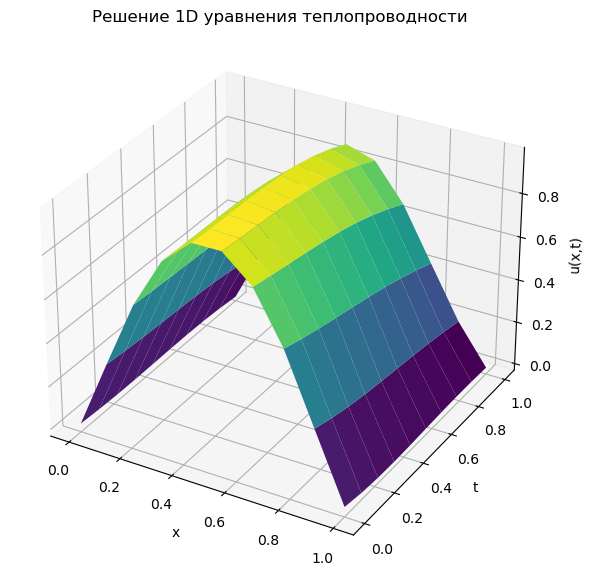

In [178]:
# Визуализация
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_plot.detach().numpy() , t_plot.detach().numpy() , u_plot.detach().numpy() , cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('u(x,t)')
ax.set_title('Решение 1D уравнения теплопроводности')
plt.show()